In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.fillings import (sigma_variance, 
                             sigma_variance_oob,
                             sigma_knn,
                             sigma_knn_oob,
                             binning)

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction_intervals(data, y_test):
    # Create two lists for lower and upper bounds of the intervals
    lower_bounds = data[:, 0]
    upper_bounds = data[:, 1]

    # Calculate medians
    medians = (lower_bounds + upper_bounds) / 2

    # Calculate interval sizes and their mean and median
    interval_sizes = upper_bounds - lower_bounds
    mean_interval_size = np.mean(interval_sizes)
    median_interval_size = np.median(interval_sizes)

    # Create an array for x-axis
    observations = np.arange(len(data))

    # Plotting
    plt.figure(figsize=(12, 6))

    # Loop through observations and create a line for each interval
    for i, (lower, upper, median) in enumerate(zip(lower_bounds, upper_bounds, medians)):
        plt.hlines(i, lower, upper, colors='blue', alpha=0.5)
        plt.hlines(i, median, median, colors='green', alpha=0.5, linestyles='dashed', lw=2)

    # Color code and size the real data points
    colors = ['green' if lower <= y <= upper else 'red' for y, lower, upper in zip(y_test, lower_bounds, upper_bounds)]
    sizes = [50 if color == 'red' else 10 for color in colors]
    plt.scatter(y_test, observations, color=colors, s=sizes)

    plt.ylabel('Observation')
    plt.xlabel('Prediction Interval')
    plt.title('Prediction Intervals for Each Observation')

    # Calculate and add percentage info
    within_interval = colors.count('green')
    total_points = len(colors)
    percentage_within = (within_interval / total_points) * 100

    # Add mean and median interval size
    plt.text(0.98, 0.98, f'Mean interval size: {mean_interval_size:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes)
    plt.text(0.98, 0.93, f'Median interval size: {median_interval_size:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes)

    # Move the percentage of points text to below the other text
    plt.text(0.98, 0.88, f'{percentage_within:.2f}% of points within interval', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes)

    # Create legend for the points
    plt.scatter([], [], color='green', label='Inside interval', s=10)
    plt.scatter([], [], color='red', label='Outside interval', s=50)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    
    plt.grid(True)
    plt.show()

    
    import matplotlib.pyplot as plt


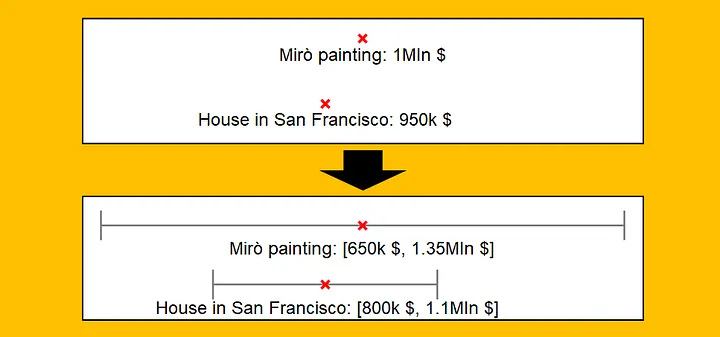

In [2]:
Image(filename='/home/usuario/Downloads/regressor_conformal.jpg')

In [9]:
CONFIDENCE_LEVEL=0.999

In [10]:
dataset = fetch_openml(name="house_sales",version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

/home/usuario/Documentos/pyprojects/calibration_seminar/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [11]:
y.max(),y.min(),y.mean(),y.std()

(1.0, 0.0, 0.06099516613331533, 0.048146715171327514)

# 1. ML as Usual

In [12]:
np.random.seed(602211023)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

rf= RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True) 

rf.fit(X_prop_train, y_prop_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

# 2. A Conformal Wrapper

In [13]:
cr_std = ConformalRegressor()
cr_std

ConformalRegressor(fitted=False)

In [14]:
y_hat_cal = rf.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals=residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

**All the uncertainty are of equal width! We can do it better :)**

In [15]:
y_hat_test = rf.predict(X_test)

intervals = cr_std.predict(y_hat=y_hat_test, y_min=0, confidence=CONFIDENCE_LEVEL)

intervals

array([[0.        , 0.26408301],
       [0.        , 0.25088064],
       [0.        , 0.29185018],
       ...,
       [0.        , 0.32062355],
       [0.        , 0.24723841],
       [0.        , 0.25681032]])

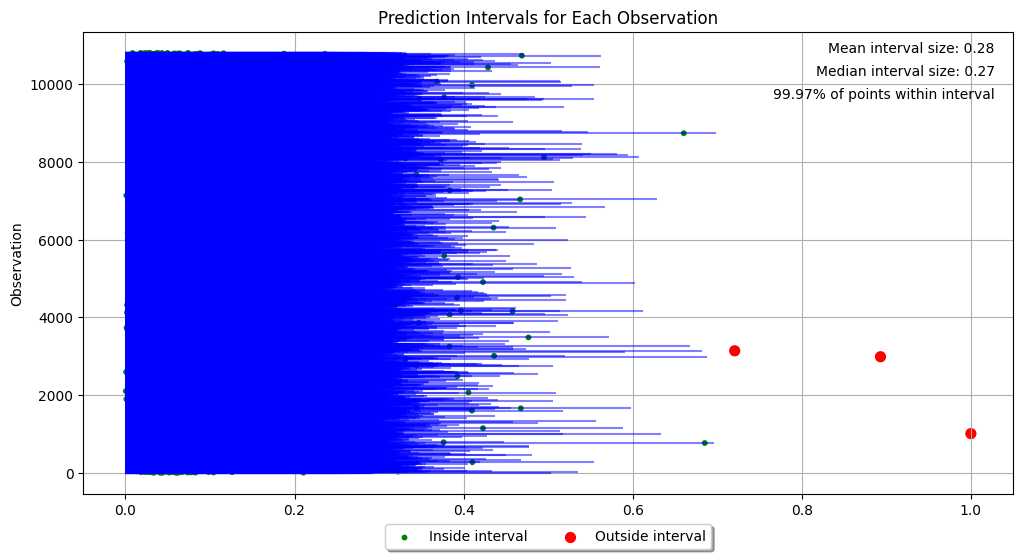

In [37]:
plot_prediction_intervals(intervals, y_test)

## 2.1 Mondrian a.k.a. Partioning the Predictions Space

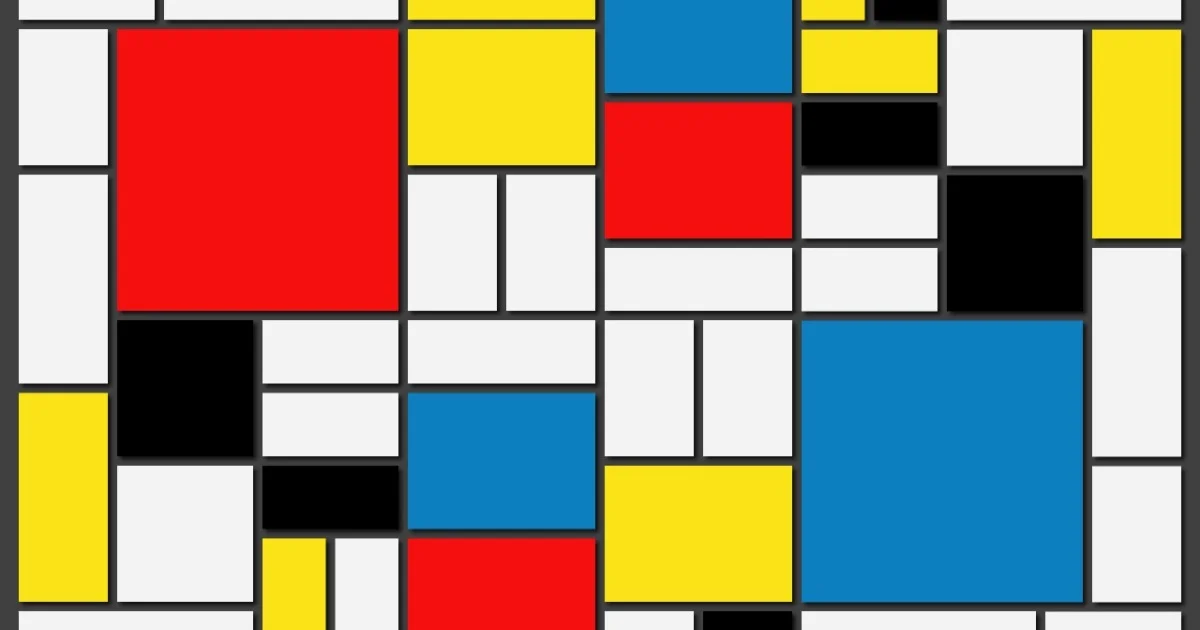

In [13]:
Image(filename='/home/usuario/Downloads/mondrian.jpg')

In [24]:
sigmas_cal_knn_std = sigma_knn(X=X_cal, X_ref=X_prop_train, y_ref=y_prop_train)

bins_cal, bin_thresholds = binning(values=sigmas_cal_knn_std, bins=11)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals=residuals_cal, bins=bins_cal)

cr_mond

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

In [25]:
sigmas_test_knn_std = sigma_knn(X=X_test, X_ref=X_prop_train, y_ref=y_prop_train)

bins_test = binning(values=sigmas_test_knn_std, bins=bin_thresholds)
intervals_mond = cr_mond.predict(y_hat=y_hat_test, bins=bins_test, 
                                         y_min=0)

intervals_mond

array([[0.01791536, 0.06391283],
       [0.01003181, 0.04539163],
       [0.        , 0.16827201],
       ...,
       [0.07560848, 0.11930078],
       [0.01410676, 0.03403221],
       [0.01179525, 0.05548755]])

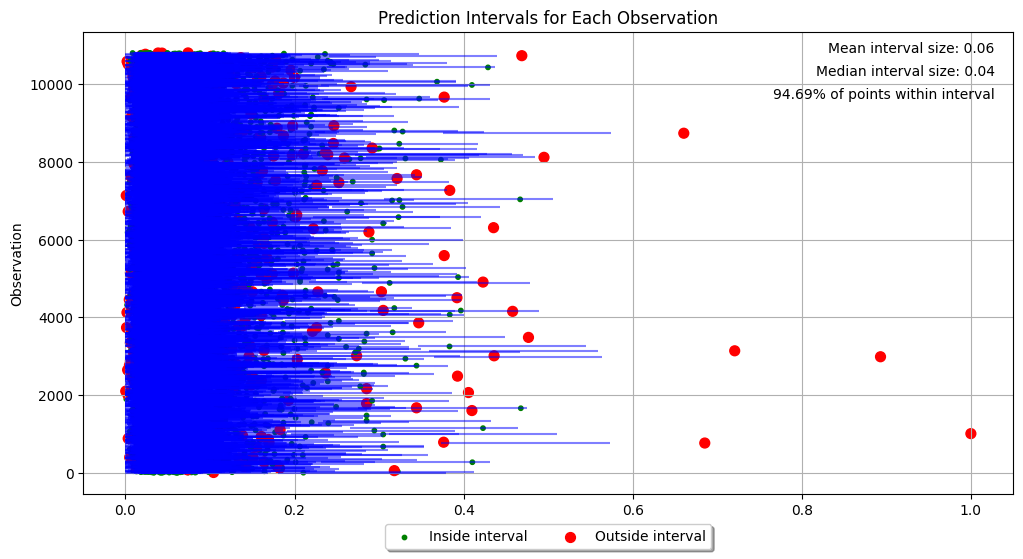

In [36]:
plot_prediction_intervals(intervals_mond, y_test)

In [12]:
all_cr = {"Mond CR": (cr_mond, sigmas_test_knn_std)}

confidence_levels = [0.20,0.80,0.9,0.95,0.99]

names = list(all_cr.keys())

all_results = {}

for confidence in confidence_levels:
    for name in names:
        all_results[(name,confidence)] = all_cr[name][0].evaluate(
        y_hat=y_hat_test, y=y_test, sigmas=all_cr[name][1],
        bins=bins_test, confidence=confidence, 
        y_min=0, y_max=1)

results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
    [names,confidence_levels]), index=list(list(
    all_results.values())[0].keys()))

for key in all_results.keys():
    results_df[key] = all_results[key].values()

results_df.round(4)

Mond CR                                
                 0.20    0.80    0.90    0.95    0.99
error          0.7953  0.2061  0.1028  0.0531  0.0077
eff_mean       0.0046  0.0284  0.0426  0.0559  0.1038
eff_med        0.0039  0.0252  0.0344  0.0437  0.0783
time_fit       0.0003  0.0003  0.0003  0.0003  0.0003
time_evaluate  0.0026  0.0017  0.0017  0.0016  0.0013

**Cereja do bolo. CDF de regressores!** 

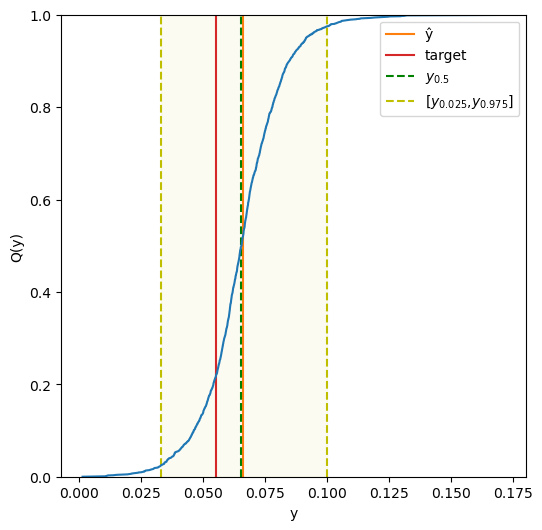

In [4]:
Image(filename='/home/usuario/Downloads/regression_cdf.png')